# Quantum Machine Learning for Music Genre Classification

The aim of the this tutorial is to demonstrate use of HierarQcal to create quantum circuit models for classification tasks. Specifically for this tutorial we will use the [GTZAN dataset](https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification?resource=download) to classify country and rock songs.

We start with a 30-s recording of a song (Fig. 1a) and we can transform it in two ways. The ﬁrst is tabular form(Fig. 1b), derived from standard digital signal processing statistics of the audio signal. The second is image form (Fig. 1c), constructed using a Mel-frequency spectrogram. In this tutorial, we will use the tabular form data.

<center>
<img src="https://unitary.fund/images/2023_hierarqcal_qcnn_pipeline.svg" alt='qcnn_genre_classification'/>
</center>

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import namedtuple
from ml_collections import config_dict
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import pennylane as qml
from pennylane.templates.embeddings import AngleEmbedding
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from hierarqcal import Qcycle, Qmask, Qinit, Qunitary, Qmotif

seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

# Set a fixed value for the hash seed
os.environ["PYTHONHASHSEED"] = str(seed)
print(f"Random seed set as {seed}")

Random seed set as 42


## Preparing the data

We create a `data_config` object which holds the required configuration for the data and its preprocessing. Since the data is in tabular form, we use Principal Component Analysis (PCA) before encoding it in a quantum state. We show the use of both angle and amplitude encoding here and test them across different instances of an architecture family.

In [2]:
data_config = config_dict.ConfigDict()
data_config.data_path = "data/features_30_sec.csv"
data_config.genres = ("classical", "rock")
data_config.split = 0.3
data_config.num_pca_components = 8
data_config.batch_size = 16
data_config.num_workers = 4

The pipeline first transform features by scaling it between $[0, \pi/2]$ followed by Principal Component Analysis to the specified components.

In [3]:
# setup preprocessing pipeline
pipeline = Pipeline(
    [
        (
            "scaler",
            preprocessing.MinMaxScaler((0, np.pi / 2)),
        ),
        ("pca", PCA(data_config.num_pca_components)),
    ]
)

In [4]:
Samples = namedtuple("samples", ["x_train", "x_test", "y_train", "y_test"])

In [5]:
def get_raw_samples(cfg):
    data = pd.read_csv(cfg.data_path)
    data = data.drop(columns=["filename", "length"])        # remove filename and length columns
    genres = cfg.genres                                     # specify genre pair
    data = data[data["label"].isin(genres)]                 # filter data
    data["label"] = data["label"].map({genres[0]: 0, 
                                       genres[1]: 1})       # set label to 0 or 1
    target = "label"                                        # specify target and features
    X, y = data.drop(columns=[target]), data[target]
    X, y = X.to_numpy(), y.to_numpy()
    
    # create train test split
    samples_raw = Samples(*train_test_split(X, y, test_size=cfg.split, random_state=seed, stratify=y))
    return samples_raw

In [6]:
def get_preprocessed_samples(samples, pipeline):
    return Samples(
        pipeline.fit_transform(samples.x_train),
        pipeline.transform(samples.x_test),
        samples.y_train,
        samples.y_test,
    )

In [7]:
def get_datasets(samples):
    train_dataset = TensorDataset(torch.Tensor(samples.x_train), torch.LongTensor(samples.y_train))
    test_dataset = TensorDataset(torch.Tensor(samples.x_test), torch.LongTensor(samples.y_test))
    return train_dataset, test_dataset

Using the preprocessed samples, we can create PyTorch data loaders for training and testing.

In [8]:
samples_raw = get_raw_samples(data_config)
samples_preprocessed = get_preprocessed_samples(samples_raw, pipeline)
train_dataset, test_dataset = get_datasets(samples_preprocessed)

train_loader = DataLoader(train_dataset, data_config.batch_size, shuffle=True, num_workers=data_config.num_workers)
test_loader = DataLoader(test_dataset, data_config.batch_size, num_workers=data_config.num_workers)

## Quantum Convolutional Neural Network with HierarQcal

The model is created by extending the `nn.Module` class. It takes a `QNode`as an argument and uses PennyLane's `TorchLayer` class to interface with PyTorch.

In [9]:
class QCNN(nn.Module):
    """QCNN for classification"""
    def __init__(self, qnode, weight_shapes):
        super().__init__()
        self.qlayer = qml.qnn.TorchLayer(qnode, weight_shapes)
        self.loss_func = nn.NLLLoss()
        
    def forward(self, x):
        return self.qlayer(x) 

    def training_step(self, batch):
        x, y = batch 
        logits = self(x)                  # Generate predictions
        loss = self.loss_func(logits, y)  # Calculate loss
        acc = accuracy(logits, y)           # Calculate accuracy
        return loss, acc

    def validation_step(self, batch):
        x, y = batch 
        logits = self(x)                    # Generate predictions
        loss = self.loss_func(logits, y)   # Calculate loss
        acc = accuracy(logits, y)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, train_acc: {:.4f}".format(epoch, result['train_loss'], result['train_acc']))

We create a helper function which takes a `motif` object (which is the QCNN created using HierarQcal) and the type of embedding to use. This function returns `QNode` object which can be passed to the PyTorch's `QCNN` class defined above.

In [10]:
# set up pennylane circuit
def get_circuit(hierq, embedding='AngleEmbedding', **kwargs):
    dev = qml.device("default.qubit", wires=hierq.tail.Q)

    @qml.qnode(dev, interface="torch")
    def circuit(inputs, weights):
        getattr(qml, embedding)(features=inputs, wires=hierq.tail.Q, **kwargs)
        hierq.set_symbols(weights)
        hierq(backend="pennylane")  # This executes the compute graph in order
        return qml.probs(wires=hierq.head.Q[0])

    return circuit

In [11]:
# Create Qcnn
def penny_gate_to_function(gate):
    return lambda bits, symbols: gate(*symbols, wires=[*bits])

In [12]:
primitive_gates = ["CRZ", "CRX", "CRY", "RZ", "RX", "RY", "Hadamard", "CNOT", "PauliX"]
penny_gates = [getattr(qml, gate_name) for gate_name in primitive_gates]
hierq_gates = {
    primitive_gate: Qunitary(
        penny_gate_to_function(penny_gate),
        n_symbols=penny_gate.num_params,
        arity=penny_gate.num_wires,
    )
    for primitive_gate, penny_gate in zip(primitive_gates, penny_gates)
}

In [13]:
# ========================================== 
# Example 1
def ansatz(bits, symbols):  # 10 params
    qml.RX(symbols[0], wires=bits[0])
    qml.RX(symbols[1], wires=bits[1])
    qml.RZ(symbols[2], wires=bits[0])
    qml.RZ(symbols[3], wires=bits[1])
    qml.CRZ(symbols[4], wires=[bits[1], bits[0]])
    qml.CRZ(symbols[5], wires=[bits[0], bits[1]])
    qml.RX(symbols[6], wires=bits[0])
    qml.RX(symbols[7], wires=bits[1])
    qml.RZ(symbols[8], wires=bits[0])
    qml.RZ(symbols[9], wires=bits[1])

In [14]:
qcnn = (
    Qinit(8)
    + (
        Qcycle(
            stride=1,
            step=1,
            offset=0,
            mapping=Qunitary(ansatz, n_symbols=10, arity=2),
            share_weights=True,
        )
        + Qmask("!*", mapping=hierq_gates["CNOT"])
    )
    * 3
)

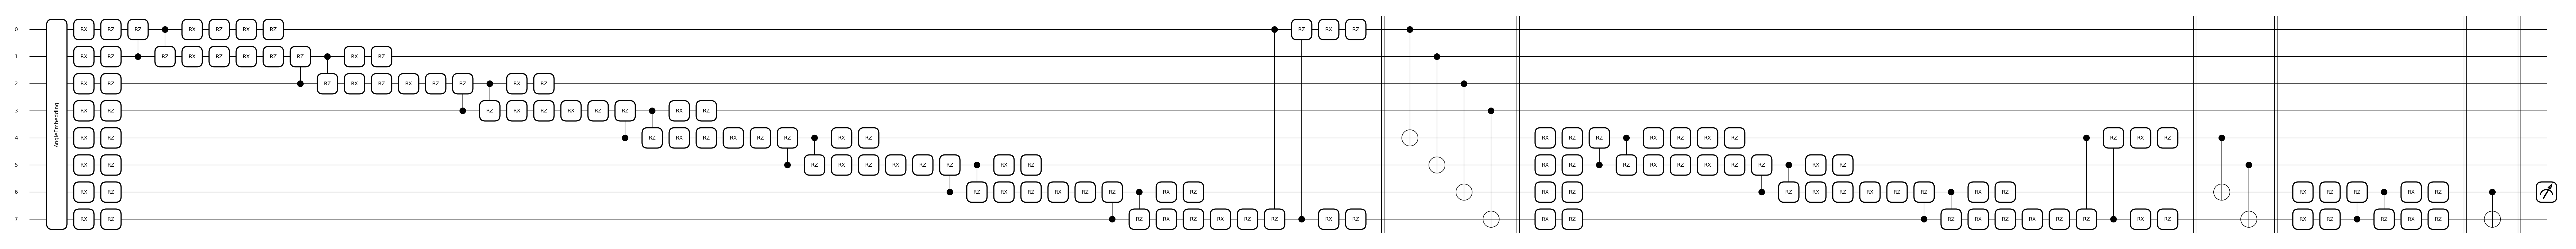

In [15]:
# plot circuit
x, w = torch.rand(8), torch.rand(qcnn.n_symbols)
fig, ax = qml.draw_mpl(get_circuit(qcnn, rotation='Y'))(x, w)

We use simple accuracy metric which tells the percentage of labels that were predicted correctly. We also have and `evaluate` function for testing our model.

In [16]:
def accuracy(outputs, labels):
    preds = outputs.argmax(dim=1, keepdim=True)
    return torch.tensor(preds.eq(labels.view_as(preds)).sum().item() / len(preds))
    
def evaluate(model, loader):
    outputs = [model.validation_step(batch) for batch in loader]
    return model.validation_epoch_end(outputs)

## Training

Since we have defined the data loaders and model, we can train the model. The `fit` function records the train loss and accuracy from each epoch and returns a history of the training process. 

In [17]:
def fit(cfg, model, train_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), cfg.learning_rate)
    for epoch in range(cfg.num_epochs):
        # Training Phase 
        batch_losses, batch_accs = [], []
        for batch in train_loader:
            loss, acc = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            batch_losses.append(loss)
            batch_accs.append(acc)

        epoch_loss = torch.stack(batch_losses).mean()
        epoch_acc = torch.stack(batch_accs).mean() 
        history.append({'train_loss': epoch_loss.item(), 
                        'train_acc': epoch_acc.item()})
        model.epoch_end(epoch, history[-1])
    return history

In [18]:
weight_shapes = {"weights": qcnn.n_symbols}
model_config = config_dict.ConfigDict()
model_config.learning_rate = 0.1
model_config.num_epochs = 10
model_config.optimizer = 'Adam'

circuit = get_circuit(qcnn)
model = QCNN(circuit, weight_shapes)
optimizer = getattr(torch.optim, model_config.optimizer)

In [19]:
history = fit(model_config, model, train_loader, optimizer)

Epoch [0], train_loss: -0.5410, train_acc: 0.6991
Epoch [1], train_loss: -0.6084, train_acc: 0.9144
Epoch [2], train_loss: -0.6440, train_acc: 0.9074
Epoch [3], train_loss: -0.6804, train_acc: 0.8889
Epoch [4], train_loss: -0.7281, train_acc: 0.8935
Epoch [5], train_loss: -0.7430, train_acc: 0.9236
Epoch [6], train_loss: -0.7490, train_acc: 0.9213
Epoch [7], train_loss: -0.7504, train_acc: 0.9005
Epoch [8], train_loss: -0.7406, train_acc: 0.9074
Epoch [9], train_loss: -0.7502, train_acc: 0.9282


In [20]:
evaluate(model, test_loader)

{'val_loss': -0.755540132522583, 'val_acc': 0.9375}

With just 10 epochs our model has reached over 90% on the test set!

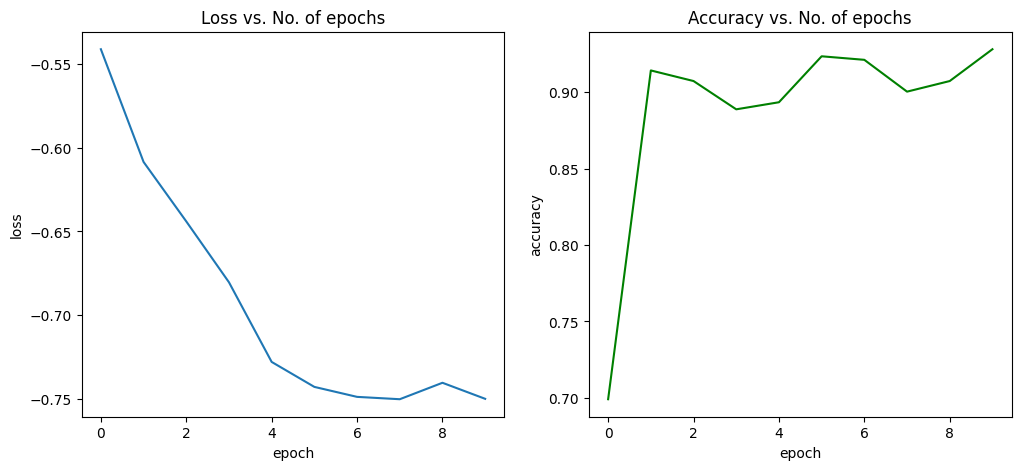

In [21]:
losses = [x['train_loss'] for x in history]
accuracies = [x['train_acc'] for x in history]

fig,ax = plt.subplots(1,2,figsize=(12,5))
ax[0].plot(losses)
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('loss')
ax[0].set_title('Loss vs. No. of epochs');

ax[1].plot(accuracies,color='green')
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('accuracy')
ax[1].set_title('Accuracy vs. No. of epochs');

### Using Amplitude Embedding

In [22]:
qcnn = (
    Qinit(3)
    + (
        Qcycle(
            stride=1,
            step=1,
            offset=0,
            mapping=Qunitary(ansatz, n_symbols=10, arity=2),
            share_weights=True,
        )
        + Qmask("!*", mapping=hierq_gates["CNOT"])
    )
    * 2
)

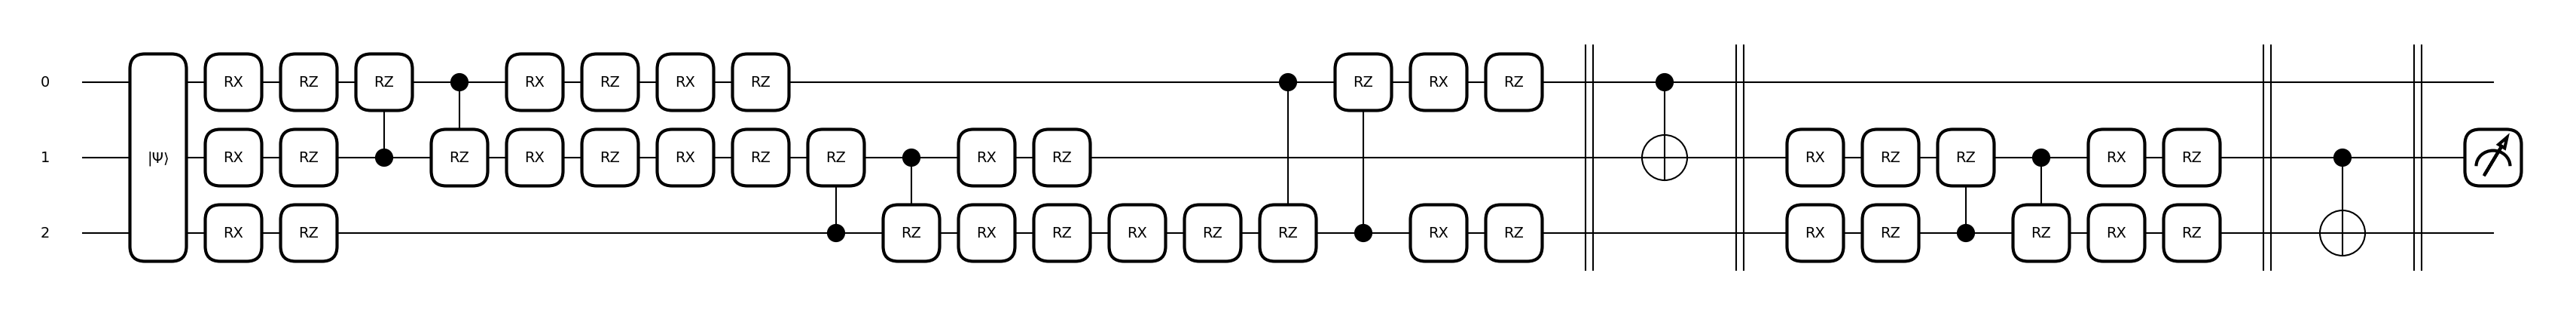

In [23]:
# plot circuit
x, w = torch.rand(8), torch.rand(qcnn.n_symbols)
fig, ax = qml.draw_mpl(get_circuit(qcnn, 'AmplitudeEmbedding', normalize=True))(x, w)

In [24]:
weight_shapes = {"weights": qcnn.n_symbols}
model_config.learning_rate = 0.05
model_config.num_epochs = 20

circuit = get_circuit(qcnn, 'AmplitudeEmbedding', normalize=True)
model = QCNN(circuit, weight_shapes)
optimizer = getattr(torch.optim, model_config.optimizer)

history = fit(model_config, model, train_loader, optimizer)

evaluate(model, test_loader)

Epoch [0], train_loss: -0.6118, train_acc: 0.7106
Epoch [1], train_loss: -0.6259, train_acc: 0.7153
Epoch [2], train_loss: -0.6284, train_acc: 0.7870
Epoch [3], train_loss: -0.6301, train_acc: 0.7755
Epoch [4], train_loss: -0.6320, train_acc: 0.7847
Epoch [5], train_loss: -0.6317, train_acc: 0.7685
Epoch [6], train_loss: -0.6324, train_acc: 0.7500
Epoch [7], train_loss: -0.6362, train_acc: 0.7894
Epoch [8], train_loss: -0.6349, train_acc: 0.7801
Epoch [9], train_loss: -0.6306, train_acc: 0.7662
Epoch [10], train_loss: -0.6320, train_acc: 0.7894
Epoch [11], train_loss: -0.6346, train_acc: 0.7870
Epoch [12], train_loss: -0.6324, train_acc: 0.7731
Epoch [13], train_loss: -0.6357, train_acc: 0.7778
Epoch [14], train_loss: -0.6327, train_acc: 0.7778
Epoch [15], train_loss: -0.6366, train_acc: 0.7778
Epoch [16], train_loss: -0.6340, train_acc: 0.7662
Epoch [17], train_loss: -0.6372, train_acc: 0.7778
Epoch [18], train_loss: -0.6366, train_acc: 0.7778
Epoch [19], train_loss: -0.6370, train_ac

{'val_loss': -0.6253038048744202, 'val_acc': 0.7552083134651184}

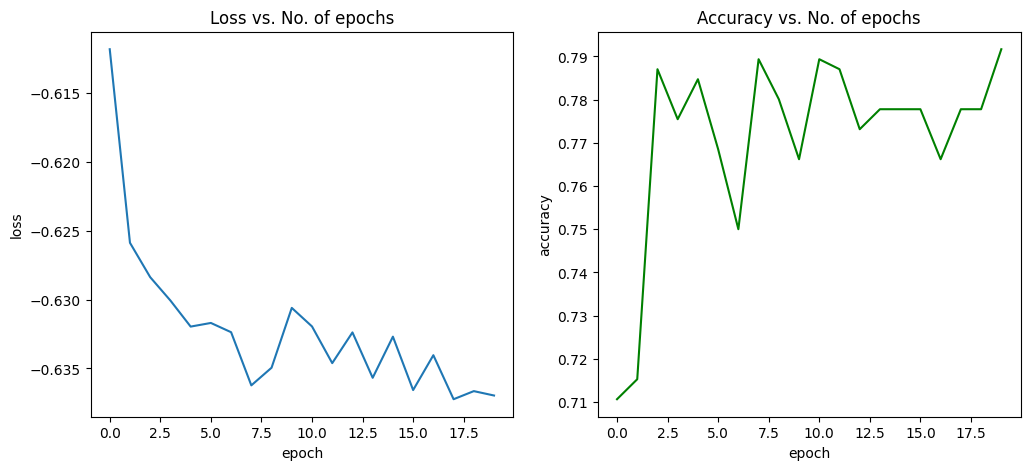

In [25]:
losses = [x['train_loss'] for x in history]
accuracies = [x['train_acc'] for x in history]

fig,ax = plt.subplots(1,2,figsize=(12,5))
ax[0].plot(losses)
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('loss')
ax[0].set_title('Loss vs. No. of epochs');

ax[1].plot(accuracies,color='green')
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('accuracy')
ax[1].set_title('Accuracy vs. No. of epochs');

In [26]:
# ========================================== 
# Example 2 Simpler ansatz, and construct it with hierarqcal...setting share_weights to False increases accuracy
ansatz = (
    Qinit(2)
    + Qmotif(E=[(0, 1)], mapping=hierq_gates["CRY"])
    + Qmotif(E=[(1, 0)], mapping=hierq_gates["CRY"])
    + Qmotif(E=[(0, 1)], mapping=hierq_gates["CNOT"])
)
# pooling ansatz
p_ansatz = (
    Qinit(2)
    + Qmotif(E=[(0, 1)], mapping=hierq_gates["CRZ"])
    + Qmotif(E=[(0,)], mapping=hierq_gates["PauliX"])
    + Qmotif(E=[(0, 1)], mapping=hierq_gates["CRX"])
)
# try setting share weights False
qcnn = (
    Qinit(8)
    + (
        Qcycle(
            stride=1,
            step=1,
            offset=0,
            mapping=ansatz,
            share_weights=True,
        )
        + Qmask("01", mapping=p_ansatz)
    )
    * 3
)

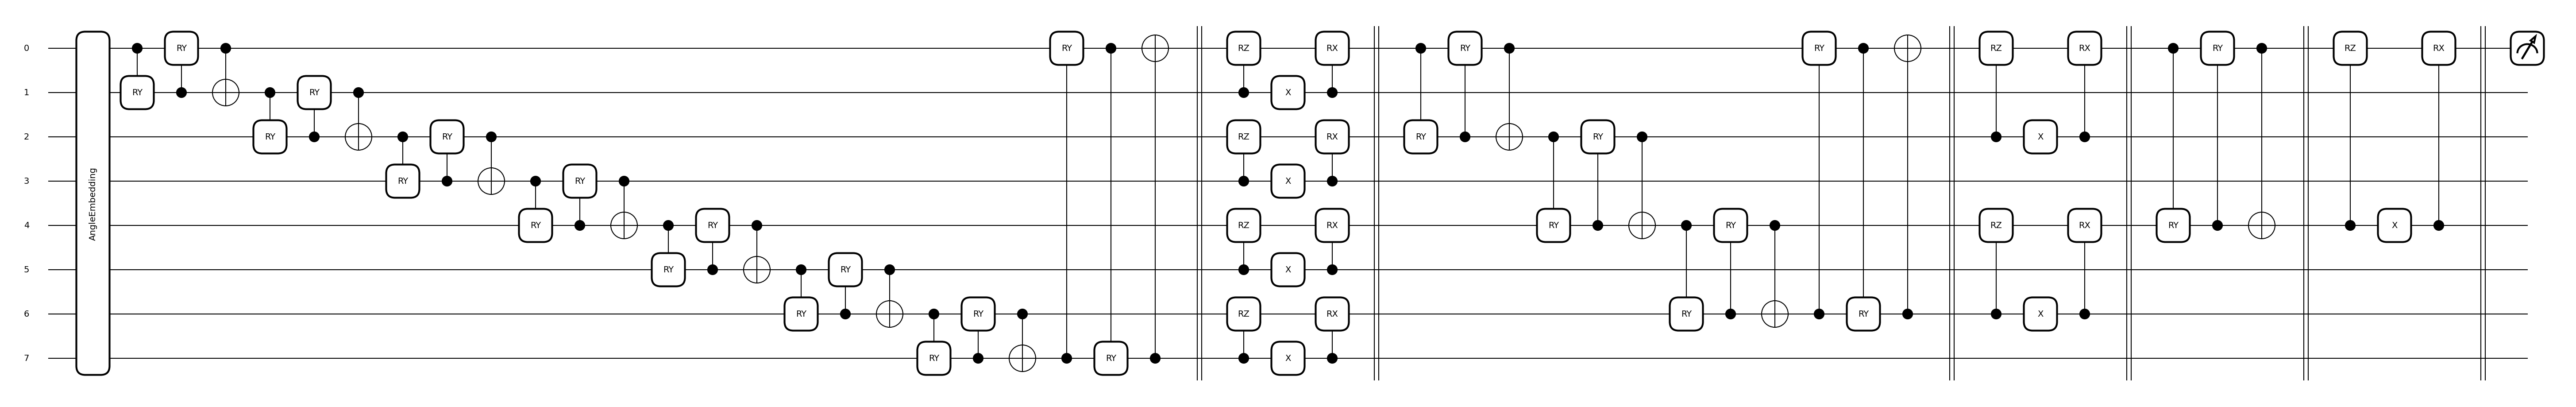

In [27]:
# plot circuit
x, w = torch.rand(8), torch.rand(qcnn.n_symbols)
fig, ax = qml.draw_mpl(get_circuit(qcnn, rotation='Y'))(x, w)

In [28]:
weight_shapes = {"weights": qcnn.n_symbols}
model_config.learning_rate = 0.1
model_config.num_epochs = 10

circuit = get_circuit(qcnn)
model = QCNN(circuit, weight_shapes)
optimizer = getattr(torch.optim, model_config.optimizer)

In [29]:
history = fit(model_config, model, train_loader, optimizer)

Epoch [0], train_loss: -0.4887, train_acc: 0.4653
Epoch [1], train_loss: -0.5100, train_acc: 0.6042
Epoch [2], train_loss: -0.5219, train_acc: 0.6250
Epoch [3], train_loss: -0.5278, train_acc: 0.6458
Epoch [4], train_loss: -0.5317, train_acc: 0.7662
Epoch [5], train_loss: -0.5390, train_acc: 0.6898
Epoch [6], train_loss: -0.5433, train_acc: 0.5625
Epoch [7], train_loss: -0.5598, train_acc: 0.7500
Epoch [8], train_loss: -0.6128, train_acc: 0.7731
Epoch [9], train_loss: -0.7007, train_acc: 0.8403


In [30]:
evaluate(model, test_loader)

{'val_loss': -0.7690232396125793, 'val_acc': 0.9375}

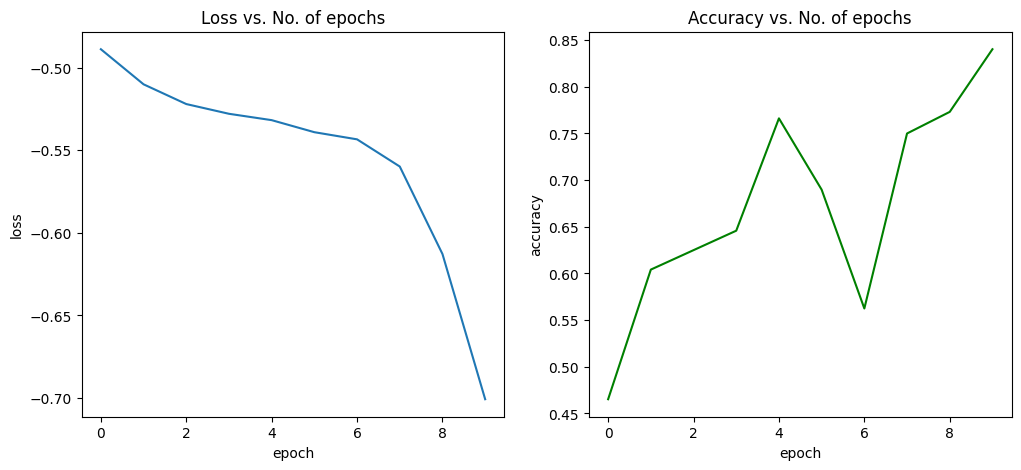

In [31]:
losses = [x['train_loss'] for x in history]
accuracies = [x['train_acc'] for x in history]

fig,ax = plt.subplots(1,2,figsize=(12,5))
ax[0].plot(losses)
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('loss')
ax[0].set_title('Loss vs. No. of epochs');

ax[1].plot(accuracies,color='green')
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('accuracy')
ax[1].set_title('Accuracy vs. No. of epochs');